# Part 5 - Merge Parcels

Merge combines two or more parent parcels into one new child parcel. Merge sums up legal areas of parent parcels to the new child parcel legal area. 

When merge is called with the `record` argument, the Merge function will update the new parcel's `CreatedByRecord` field with the `GlobalID` of the record.  It will also update the original feature's `RetiredByRecord` with the same GlobalID value.

This notebook will demonstrate:

1. Creating a branch version
2. Creating a new parcel record
3. Querying for parcels to merge
4. Merging the parcels.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Part-5---Merge-Parcels" data-toc-modified-id="Part-5---Merge-Parcels-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Part 5 - Merge Parcels</a></span><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Create-a-new-branch-version" data-toc-modified-id="Create-a-new-branch-version-1.0.0.1"><span class="toc-item-num">1.0.0.1&nbsp;&nbsp;</span>Create a new branch version</a></span></li><li><span><a href="#Create-a-new-parcel-record" data-toc-modified-id="Create-a-new-parcel-record-1.0.0.2"><span class="toc-item-num">1.0.0.2&nbsp;&nbsp;</span>Create a new parcel record</a></span></li><li><span><a href="#Query-parcels-to-merge" data-toc-modified-id="Query-parcels-to-merge-1.0.0.3"><span class="toc-item-num">1.0.0.3&nbsp;&nbsp;</span>Query parcels to merge</a></span></li><li><span><a href="#Merge-the-parcels" data-toc-modified-id="Merge-the-parcels-1.0.0.4"><span class="toc-item-num">1.0.0.4&nbsp;&nbsp;</span>Merge the parcels</a></span></li><li><span><a href="#Recocile,-Post-and-Delete-the-version" data-toc-modified-id="Recocile,-Post-and-Delete-the-version-1.0.0.5"><span class="toc-item-num">1.0.0.5&nbsp;&nbsp;</span>Recocile, Post and Delete the version</a></span></li></ul></li><li><span><a href="#API-Ref-Documentation" data-toc-modified-id="API-Ref-Documentation-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>API Ref Documentation</a></span></li></ul></li></ul></li></ul></div>

In [40]:
from arcgis import GIS
from arcgis.features.layer import FeatureLayer
from arcgis.features.layer import FeatureLayerCollection

In [41]:
base_server_url = (
    "https://rextapilnx02eb.mysite.com/server/rest/services/WashingtonCounty/"
)
gis = GIS(
    "https://myenterprisesite.com/portal/",
    "my_user_name",
    "my_secure_password",
    verify_cert=True,
)

# generate the enpoint urls for feature server, version management and parcel fabric
service_endpoints = ["FeatureServer", "ParcelFabricServer", "VersionManagementServer"]
service_urls = {url: base_server_url + url for url in service_endpoints}

## Create a new branch version

Get access to the VersionManager object through the Parcel Fabric FeatureLayerCollection

In [42]:
parcel_fabric_flc = FeatureLayerCollection(service_urls["FeatureServer"], gis)
version_management_server = parcel_fabric_flc.versions

new_version_name = "merge_version_1"

version = version_management_server.create(new_version_name)
fq_version_name = version["versionInfo"]["versionName"]
fq_version_name

'my_user_name.merge_version_1'

## Create a new parcel record
This is the name of the legal record which states two parcels should be combined into one.

In [43]:
# Get the URL of the Records feature layer
records_fl_url = [n for n in parcel_fabric_flc.layers if n.properties.name == "Records"]
records_fl_url = records_fl_url[0].url

# A name for the new record
new_record_name = "ParcelRecord001"

# Record information with empty geometry.  The geometry is created during Build
record_dict = {"attributes": {"name": new_record_name}, "geometry": None}

# Access the Records FeatureLayer object
records_fl = FeatureLayer(records_fl_url, gis)

# Create the new record within the new branch version
new_record = records_fl.edit_features(adds=[record_dict], gdb_version=fq_version_name)

new_record

{'addResults': [{'objectId': 926,
   'globalId': '{40B34F8E-BE24-4936-9A38-02C777AEE348}',
   'success': True}],
 'updateResults': [],
 'deleteResults': []}

In [44]:
# Get the globalID of the new record
record_globalid = new_record["addResults"][0]["globalId"]
record_globalid

'{40B34F8E-BE24-4936-9A38-02C777AEE348}'

## Query parcels to merge

The [Merge](/python/latest/api-reference/arcgis.features.managers.html#arcgis.features._parcel.ParcelFabricManager.merge) function takes an argument of parcel features in the following format:

```
[{"id":"<parcelguid>","layerId":"<layer_id>"},{...}]
```

This can be accomplished by identifying the layer ID of the parcels and querying the parcels by their name (PIN, APN, etc) 

In [45]:
# parcels to be queried and merged
parcel_apns = ["0031001", "0031002"]

In [46]:
# build up a WHERE IN clause to search for parcels
where_clause = "NAME in ("
for p in range(len(parcel_apns)):
    where_clause += f"'{str(parcel_apns[p])}',"
where_clause = where_clause[:-1] + ")"

where_clause

"NAME in ('0031001','0031002')"

In [47]:
# Get the URL of the parcel polygon feature layer
parcel_fl_props = [n for n in parcel_fabric_flc.layers if n.properties.name == "Tax_PF"]
parcels_fl_url = parcel_fl_props[0].url

# Get the parcels feature layer
parcels_fl = FeatureLayer(parcels_fl_url, gis)

# query the features using the WHERE clause
# use to_dict() to get access to attributes
parcels_subset = parcels_fl.query(
    where=where_clause,
    out_fields=["GlobalID"],
    gdb_version=fq_version_name,
)

parcels_subset_dict = parcels_subset.to_dict()

In [48]:
print(
    [
        (a["attributes"]["objectid"], a["attributes"]["globalid"])
        for a in parcels_subset_dict["features"]
    ]
)

[(77, '{F736D9F3-DFD9-4FEE-A2E8-07352E74EBDF}'), (79, '{13CD345B-7C4F-41C7-A22D-24E4C6670D85}')]


In [61]:
map = gis.map("Keowns, WI")
map.content.draw(parcels_subset)
map.zoom_to_layer(parcels_subset)


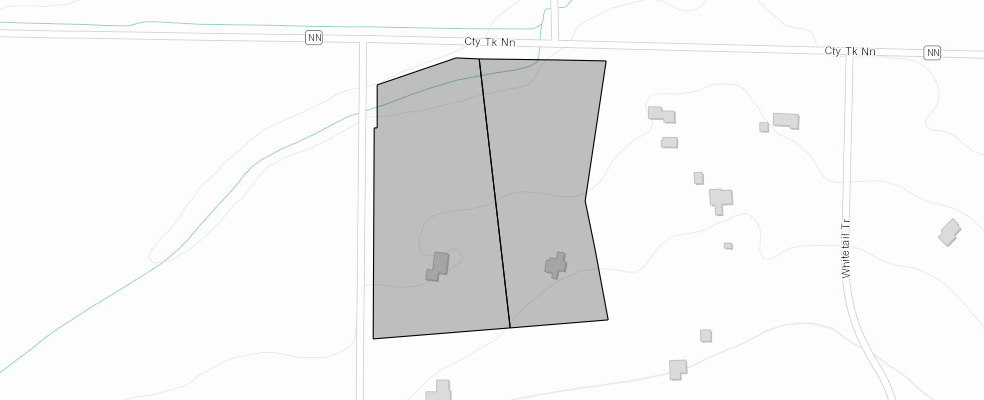

In [60]:
# Two parcels to be merged:
map

In [51]:
# Generate a list of dicts of {id: <globalid>, layerid: <layer_id>}
parcels_to_merge = []

parcels_fl_layerid = parcel_fl_props[0].properties.id

for item in parcels_subset_dict["features"]:
    parcels_to_merge.append(
        {"id": item["attributes"]["globalid"], "layerId": parcels_fl_layerid}
    )

parcels_to_merge

[{'id': '{F736D9F3-DFD9-4FEE-A2E8-07352E74EBDF}', 'layerId': 15},
 {'id': '{13CD345B-7C4F-41C7-A22D-24E4C6670D85}', 'layerId': 15}]

## Merge the parcels
- Create a simple dict of feature attributes to update merged parcel (optional)
- Start an edit session in the new version
- Get the ParcelManager object
- Pass the required arguments to the ParcelManager.merge function

In [52]:
from arcgis.features._parcel import ParcelFabricManager

# Values to update the merged parcel attributes
merged_parcel_name = "0033004"
attributes = {
    "type": "PropertySet",
    "propertySetItems": ["name", merged_parcel_name, "statedarea", 18002],
}

version_management_server.purge(fq_version_name)
# Start the edit session, get the ParcelFabricManager and merge
with version_management_server.get(fq_version_name, "read") as version:
    parcel_fabric = ParcelFabricManager(
        service_urls["ParcelFabricServer"], gis, version, parcel_fabric_flc
    )

    merge = parcel_fabric.merge(
        parent_parcels=parcels_to_merge,
        merge_record=record_globalid,
        target_parcel_type=15,
        default_area_unit=109405,
        merge_into="{00000000-0000-0000-0000-000000000000}",
        attribute_overrides=attributes,
        future=False,
    )
merge["success"]

True

In [53]:
tax_service_edits = [se for se in merge.get("serviceEdits") if se["id"] == 15][0]
merged_feature = (
    tax_service_edits.get("editedFeatures").get("adds")[0].get("attributes", {})
)
print("Name:", merged_feature.get("Name"))
print("Stated Area:", merged_feature.get("StatedArea"))

Name: None
Stated Area: None


In [54]:
merged_parcel = parcels_fl.query(
    gdb_version=fq_version_name, where=f"Name = '{merged_parcel_name}'"
)

In [59]:
map1 = gis.map("Keowns, WI")
map1.content.draw(merged_parcel)
map1.zoom_to_layer(merged_parcel)


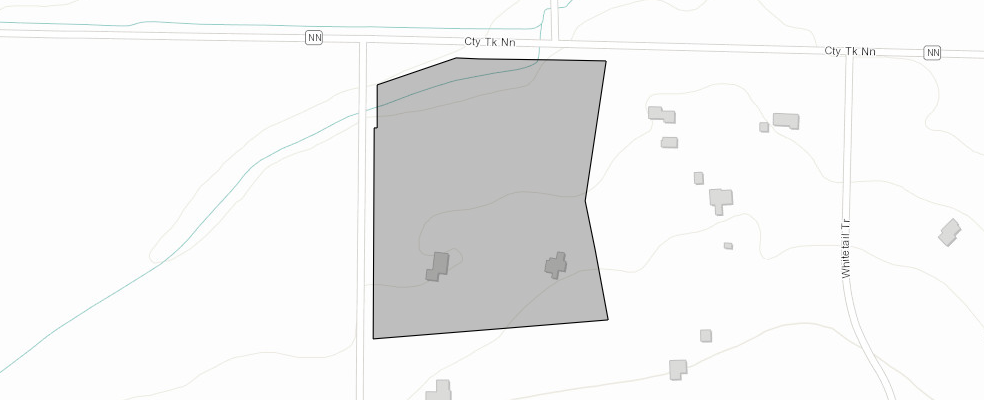

In [58]:
# Two features merged into one
map1

## Recocile, Post and Delete the version

When editing is complete, the new features can be posted from the new branch version to the default version.  In this workflow, Reconcile must occur first.  Once posted, the version can optionally be deleted.

In [ ]:
version = version_management_server.get(f"my_user_name.{new_version_name}")
version.reconcile()
version.post()
version.delete()

## API Ref Documentation

- [ArcGIS Python API - Version Manager](/python/latest/api-reference/arcgis.features.managers.html#versionmanager)
- [ArcGIS Python API - Parcel Fabric Manager](/python/latest/api-reference/arcgis.features.managers.html#parcelfabricmanager)
- [ArcGIS REST API - VersionManagementServer](/rest/services-reference/enterprise/version-management-service.htm)
- [ArcGIS REST API - ParcelFabricServer](/rest/services-reference/enterprise/overview-of-parcel-fabric-sevices.htm)
- [ArcGIS Pro - Branch Versioning Scenarios](https://pro.arcgis.com/en/pro-app/latest/help/data/geodatabases/overview/branch-version-scenarios.htm)